In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

/home/abrunhosa/Desktop/Aula11/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Unsupervised Learning

Unsupervised learning - Apply unsupervised learning to explore whether the \
intrinsic structure of the gene expression data naturally reflects the known \
cancer subtypes. Use dimensionality reduction techniques (e.g PCA or UMAP) for \
visualization and clustering algorithms (e.g K-means, hierarchical clustering). \
Are the subtypes of cancer (Classical and Mesenchymal) recapitulated using these \
methods? Generate visualizations using the results from these methods.

In [ ]:
# Load your gene expression dataset
# Assume `X` is the gene expression matrix (samples x genes)
# and `labels` contains known subtypes: ['Classical', 'Mesenchymal']
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
labels = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

# Standardize
X_std = (X - X.mean()) / X.std()

# --------------------
# Dimensionality Reduction
# --------------------
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_std)


/home/abrunhosa/Desktop/Aula11/venv/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [3]:
# --------------------
# Clustering
# --------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_std)

hierarchical = AgglomerativeClustering(n_clusters=2)
hier_labels = hierarchical.fit_predict(X_std)

/home/abrunhosa/Desktop/Aula11/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
# --------------------
# Evaluation (if labels known)
# --------------------
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(labels, kmeans_labels)

ari_hier = adjusted_rand_score(labels, hier_labels)
nmi_hier = normalized_mutual_info_score(labels, hier_labels)

print(f"KMeans - ARI: {ari_kmeans:.2f}, NMI: {nmi_kmeans:.2f}")
print(f"Hierarchical - ARI: {ari_hier:.2f}, NMI: {nmi_hier:.2f}")



KMeans - ARI: 0.02, NMI: 0.01
Hierarchical - ARI: 0.00, NMI: 0.00


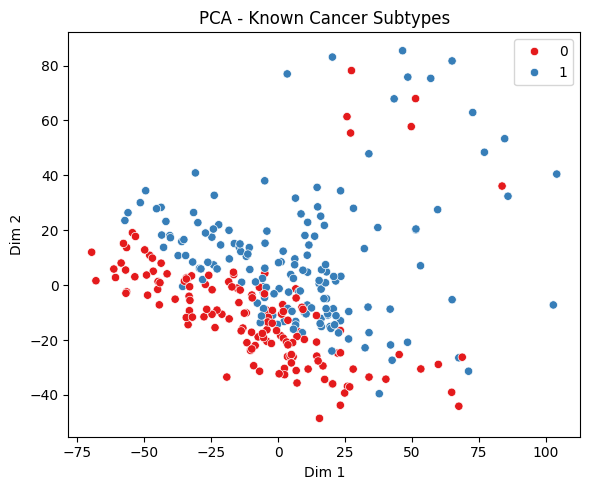

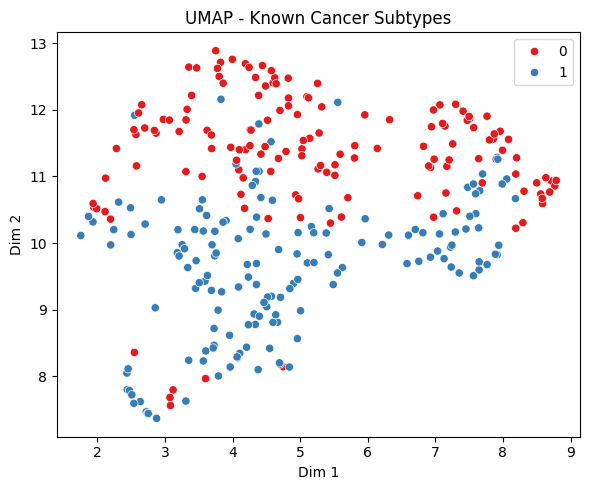

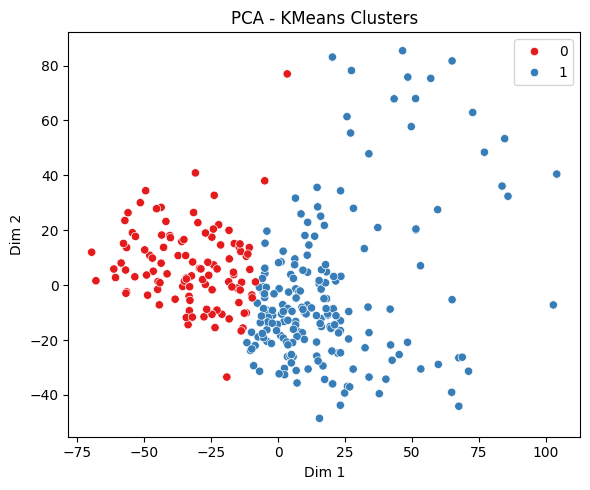

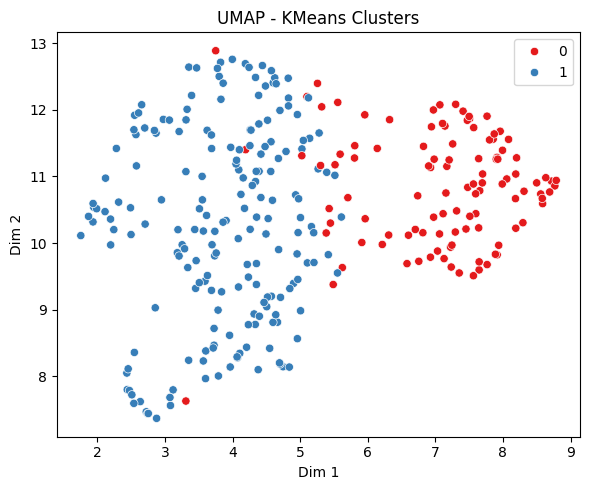

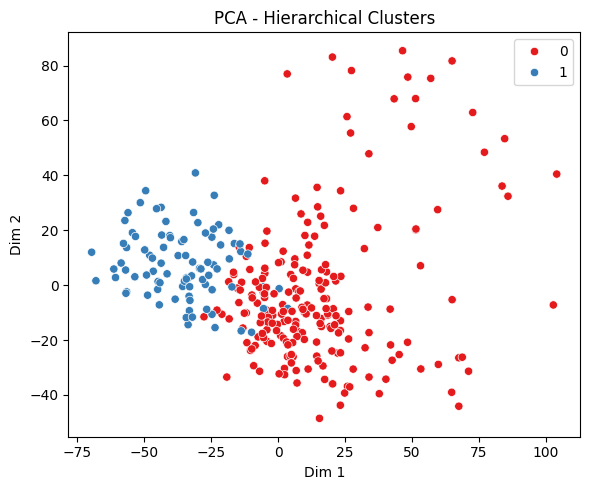

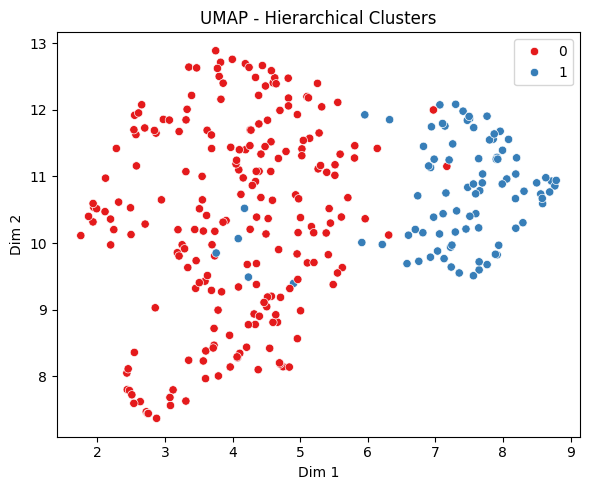

In [5]:
# --------------------
# Visualization
# --------------------
def plot_embedding(X_embed, labels, title):
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_embed[:,0], y=X_embed[:,1], hue=labels, palette="Set1")
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot PCA / UMAP colored by known subtypes
plot_embedding(X_pca, labels, "PCA - Known Cancer Subtypes")
plot_embedding(X_umap, labels, "UMAP - Known Cancer Subtypes")

# Plot PCA / UMAP colored by KMeans clusters
plot_embedding(X_pca, kmeans_labels, "PCA - KMeans Clusters")
plot_embedding(X_umap, kmeans_labels, "UMAP - KMeans Clusters")

# Plot PCA / UMAP colored by Hierarchical Clusters
plot_embedding(X_pca, hier_labels, "PCA - Hierarchical Clusters")
plot_embedding(X_umap, hier_labels, "UMAP - Hierarchical Clusters")

# Supervised Learning

Build a binary classifier capable of distinguishing between the Classical \
(prognostically favourable) and Mesenchymal (prognostically adverse) subtypes. \
A possible pipeline for this task is outlined below and should guide you in building \
and evaluating your subtype classification model using gene expression data

## Data Preprocessing

Loading data 
Encoding data

In [ ]:

# --------------------
# Load Data
# --------------------
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
y = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Classical = 0, Mesenchymal = 1

Selecting the most relevants features

In [7]:

# (a) Variance Threshold
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)

# (b) ANOVA F-test - select top 100 features
select_k = 100
fs = SelectKBest(score_func=f_classif, k=select_k)
X_selected = fs.fit_transform(X_vt, y_encoded)

In [8]:
# --------------------
# Standardization
# --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# --------------------
# Classifier
# --------------------
clf = LogisticRegression(max_iter=1000)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_scaled, y_encoded, cv=cv, scoring='roc_auc')

print(f"Mean ROC AUC: {scores.mean():.3f} ± {scores.std():.3f}")

Mean ROC AUC: 0.978 ± 0.014


In [9]:
# --------------------
# Set up scorers
# --------------------
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [10]:
# --------------------
# Classifier 1: Logistic Regression
# --------------------
log_reg_results = []
for C in [0.01, 0.1, 1, 10]:
    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=300)),
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(C=C, max_iter=1000))
    ])
    scores = cross_validate(pipeline, X, y_encoded, cv=cv, scoring=scoring)
    log_reg_results.append({
        'Model': f'LogReg (C={C})',
        **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}"
           for metric in scoring}
    })

** Random Forest **

In [11]:
# --------------------
# Classifier 2: Random Forest
# --------------------
rf_results = []
for n_estimators in [50, 100]:
    for max_depth in [None, 10, 20]:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=f_classif, k=300)),
            ('clf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42))
        ])
        scores = cross_validate(pipeline, X, y_encoded, cv=cv, scoring=scoring)
        rf_results.append({
            'Model': f'RF (n={n_estimators}, depth={max_depth})',
            **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}"
               for metric in scoring}
        })

In [13]:
# --------------------
# Display Results
# --------------------
results_df = pd.DataFrame(log_reg_results + rf_results)
results_df

,Model,accuracy,precision,recall,f1
0,LogReg (C=0.01),0.934 ± 0.021,0.937 ± 0.017,0.936 ± 0.053,0.936 ± 0.022
1,LogReg (C=0.1),0.914 ± 0.020,0.934 ± 0.020,0.898 ± 0.032,0.915 ± 0.021
2,LogReg (C=1),0.904 ± 0.020,0.922 ± 0.023,0.891 ± 0.034,0.906 ± 0.021
3,LogReg (C=10),0.897 ± 0.023,0.909 ± 0.023,0.891 ± 0.034,0.900 ± 0.023
4,"RF (n=50, depth=None)",0.917 ± 0.021,0.926 ± 0.025,0.917 ± 0.069,0.919 ± 0.025
5,"RF (n=50, depth=10)",0.917 ± 0.021,0.926 ± 0.025,0.917 ± 0.069,0.919 ± 0.025
6,"RF (n=50, depth=20)",0.917 ± 0.021,0.926 ± 0.025,0.917 ± 0.069,0.919 ± 0.025
7,"RF (n=100, depth=None)",0.927 ± 0.017,0.915 ± 0.017,0.949 ± 0.052,0.931 ± 0.019
8,"RF (n=100, depth=10)",0.927 ± 0.017,0.915 ± 0.017,0.949 ± 0.052,0.931 ± 0.019
9,"RF (n=100, depth=20)",0.927 ± 0.017,0.915 ± 0.017,0.949 ± 0.052,0.931 ± 0.019
